Connecting 13 isolated nodes.


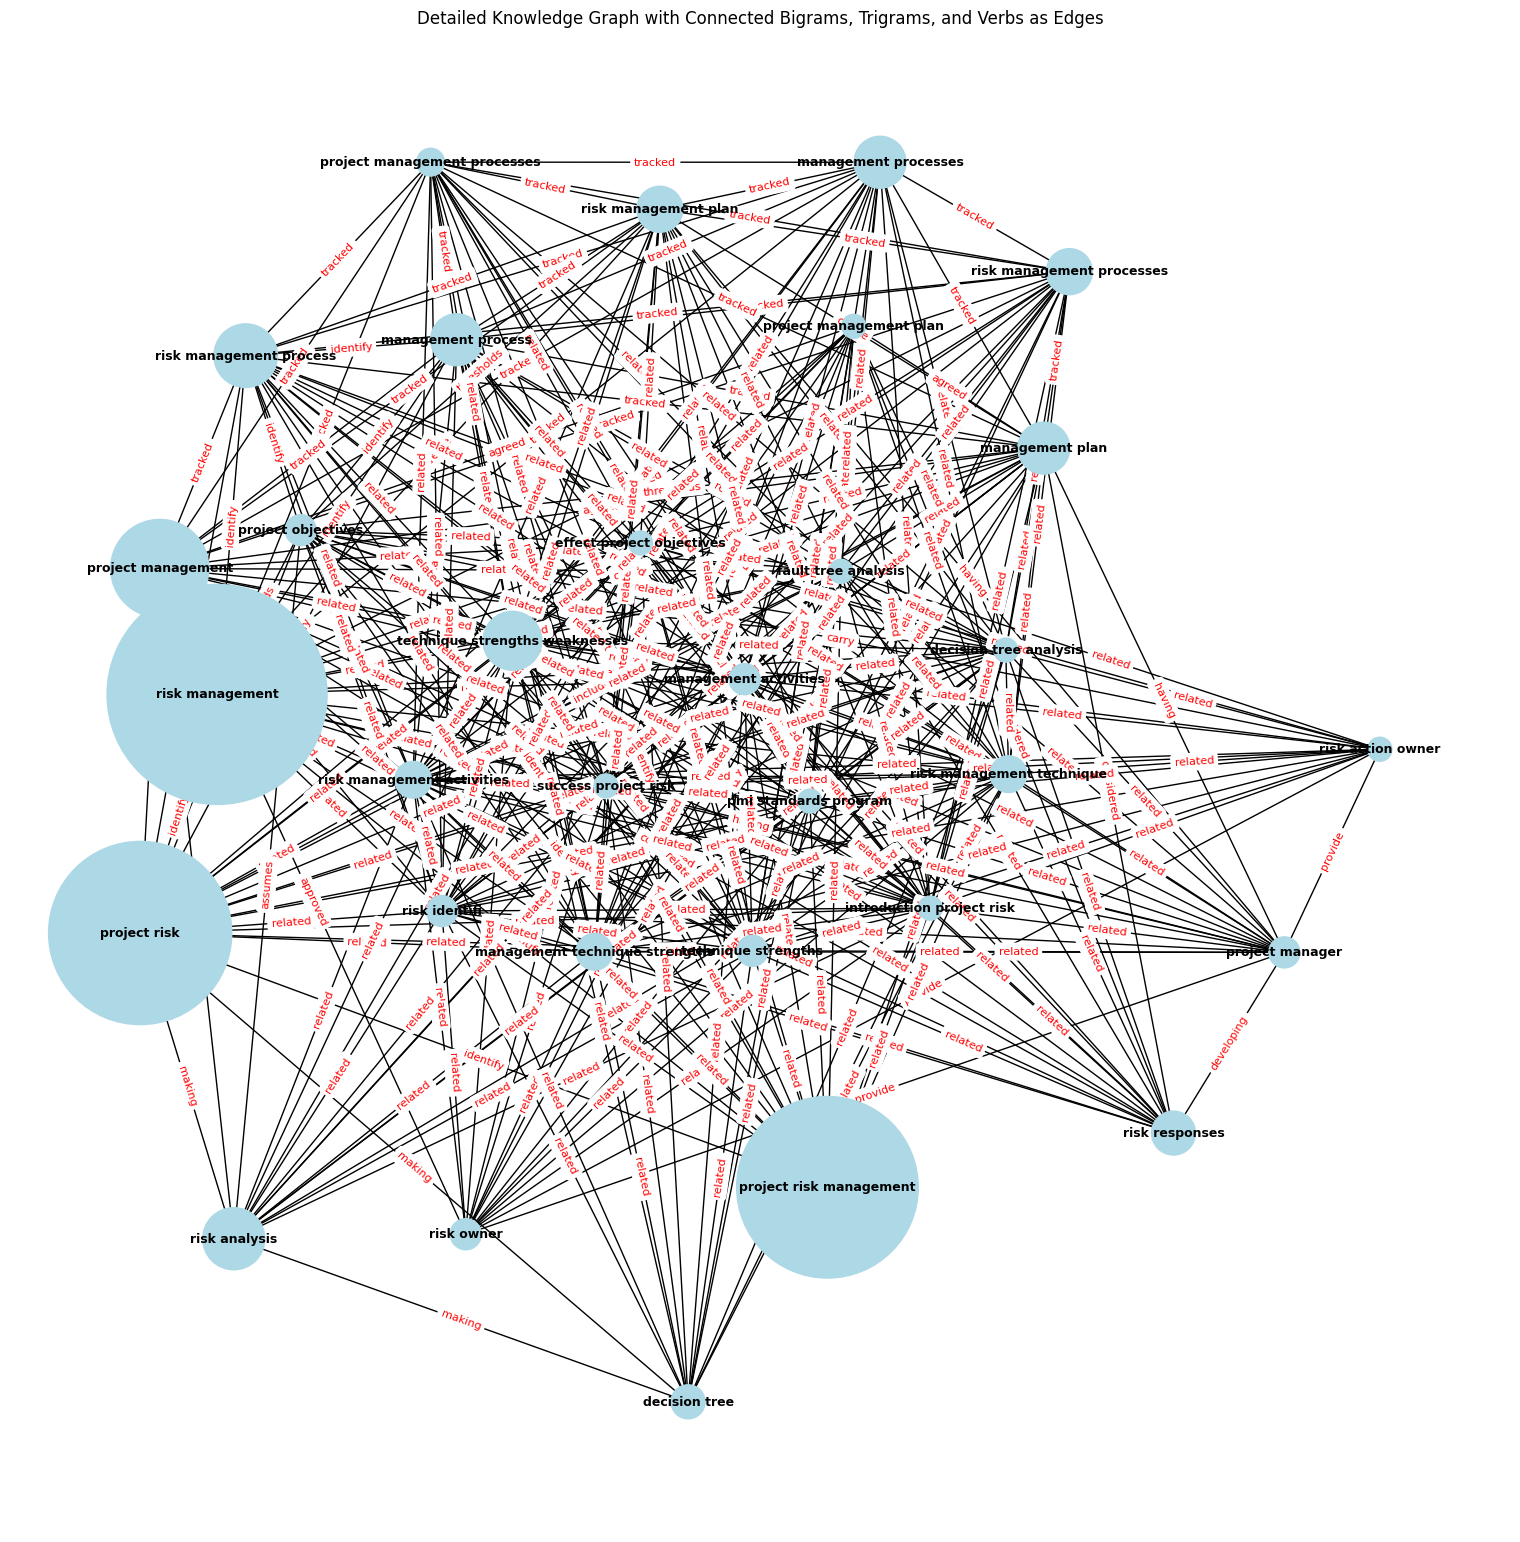

In [12]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from collections import Counter
import itertools
from sklearn.feature_extraction.text import CountVectorizer

# Load the spacy language model for verb extraction
nlp = spacy.load("en_core_web_sm")

# Load the dataframe
df = pd.read_csv('summarized_df.csv')

# Initialize an empty graph
G = nx.Graph()

# Thresholds for capturing nodes
bigram_threshold = 5
trigram_threshold = 3

# Function to get the top n-grams based on a frequency threshold
def get_top_ngrams(ngram_dict, threshold):
    return {ngram: count for ngram, count in ngram_dict.items() if count >= threshold}

# Add nodes to the graph (bigrams/trigrams)
def add_ngrams_as_nodes(ngram_dict, graph):
    for ngram, count in ngram_dict.items():
        graph.add_node(' '.join(ngram), size=count * 100)  # Adjust node size based on frequency

# Extract verbs (edges) from summarized paragraph
def extract_verbs(paragraph):
    doc = nlp(paragraph)
    verbs = [token.text for token in doc if token.pos_ == 'VERB']
    return verbs

# Extract edges between bigrams/trigrams using verbs
def extract_edges_with_verbs(paragraph, ngrams):
    doc = nlp(paragraph)
    edges = []
    found_ngrams = [ngram for ngram in ngrams if ' '.join(ngram) in paragraph]
    
    # Check for co-occurrence of ngrams and extract the verbs connecting them
    for combo in itertools.combinations(found_ngrams, 2):
        verb_edges = extract_verbs(paragraph)  # Extract verbs from paragraph
        for verb in verb_edges:  # Add an edge for each verb
            edges.append((combo[0], combo[1], verb))
    
    return edges

# Collect all bigrams and trigrams to create nodes
all_bigrams = Counter()
all_trigrams = Counter()

for index, row in df.iterrows():
    # Parse the bigram and trigram dicts
    bigrams = eval(row['bigram_dict'])
    trigrams = eval(row['trigram_dict'])

    # Get top bigrams and trigrams based on threshold
    top_bigrams = get_top_ngrams(bigrams, bigram_threshold)
    top_trigrams = get_top_ngrams(trigrams, trigram_threshold)

    # Collect all top bigrams and trigrams
    all_bigrams.update(top_bigrams)
    all_trigrams.update(top_trigrams)

# Add bigrams and trigrams as nodes to the graph
add_ngrams_as_nodes(all_bigrams, G)
add_ngrams_as_nodes(all_trigrams, G)

# Extract edges (verbs) from summarized paragraphs and create the graph
for index, row in df.iterrows():
    summarized_paragraph = row['summarized_paragraphs']
    
    # Get all bigrams and trigrams as ngrams
    ngrams = list(all_bigrams.keys()) + list(all_trigrams.keys())
    
    # Extract edges using verbs from the summarized paragraph
    edges = extract_edges_with_verbs(summarized_paragraph, ngrams)
    
    # Add the edges (with verbs) to the graph
    for edge in edges:
        G.add_edge(' '.join(edge[0]), ' '.join(edge[1]), label=edge[2])

# Step to ensure that all nodes are connected: fallback edge creation
def add_fallback_edges(G, ngrams):
    """Connect isolated nodes using a fallback edge-creation mechanism."""
    isolated_nodes = list(nx.isolates(G))
    
    if isolated_nodes:
        print(f"Connecting {len(isolated_nodes)} isolated nodes.")
        for node in isolated_nodes:
            # Find the closest node to connect (for simplicity, connect to any random existing node)
            for other_node in G.nodes:
                if other_node != node:
                    # Add fallback edge
                    G.add_edge(node, other_node, label="related")

# Ensure all nodes are connected
add_fallback_edges(G, ngrams)

# Draw the graph with labeled edges (verbs)
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.4, iterations=50)  # Adjust k and iterations for better layout

# Draw nodes with size based on frequency
node_sizes = [nx.get_node_attributes(G, 'size')[node] for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color="lightblue", font_size=9, font_weight="bold")

# Draw edge labels (verbs)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("Detailed Knowledge Graph with Connected Bigrams, Trigrams, and Verbs as Edges")
plt.show()


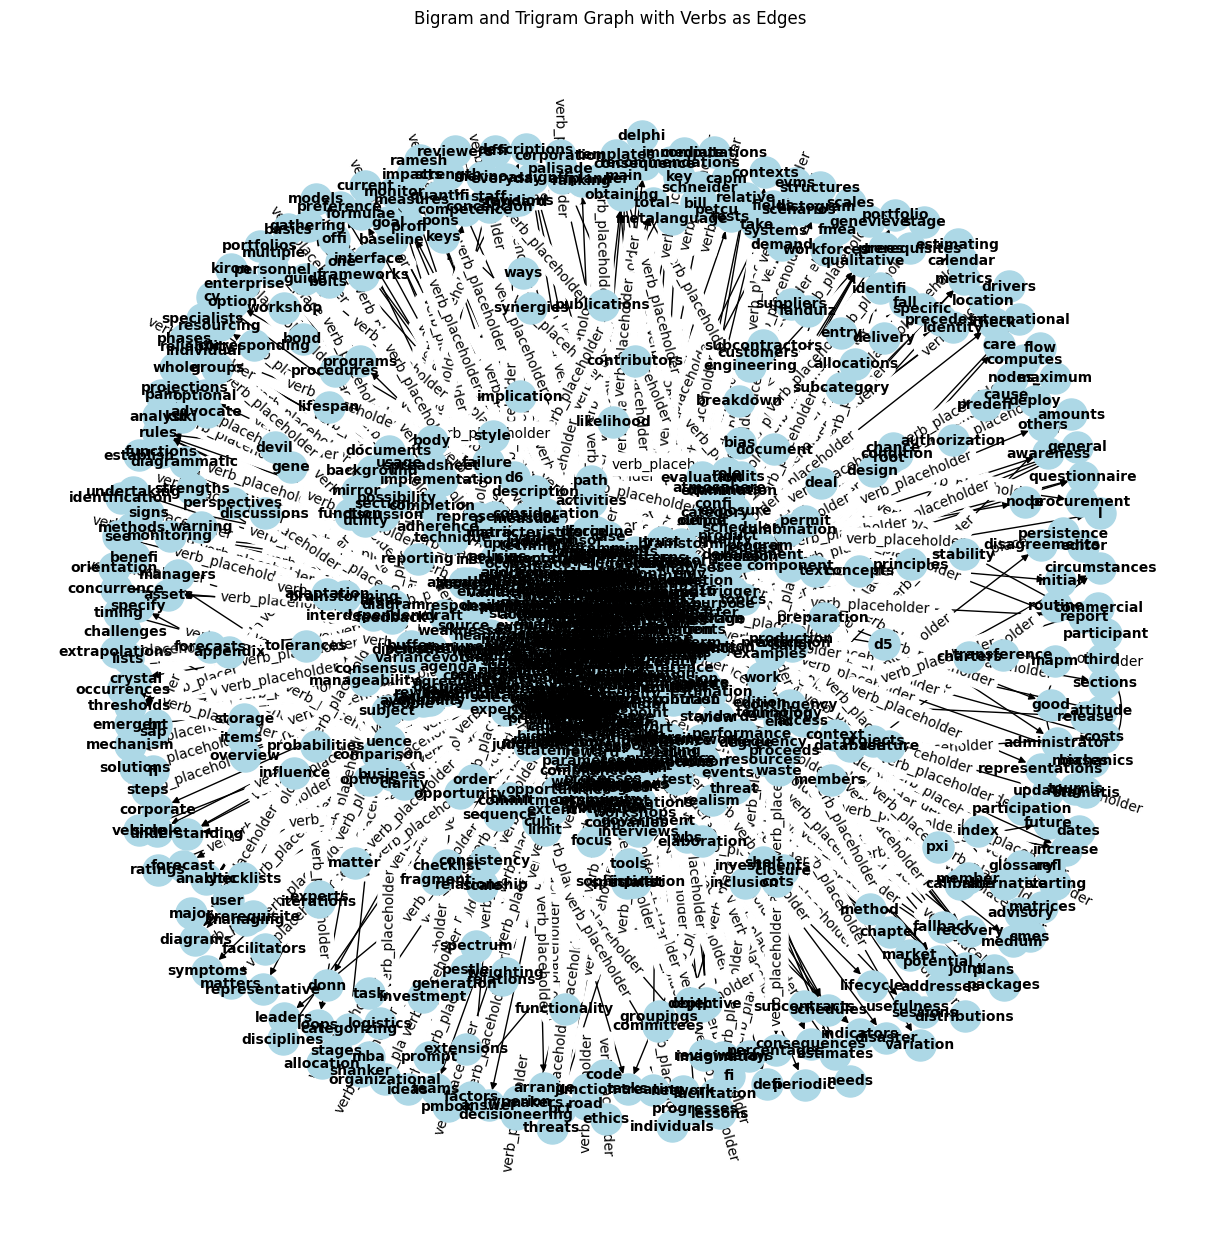

In [16]:
import pandas as pd
import ast
import re
import networkx as nx
import matplotlib.pyplot as plt

# Function to clean and extract bigrams and trigrams from the dataset
def extract_ngrams(counter_string):
    # Use regular expressions to extract tuple pairs from the string
    ngrams = re.findall(r"\('([^']+)', '([^']+)'\)", counter_string)
    return ngrams

# Load the data from CSV file
file_path = 'summarized_df.csv'  # Update this path if needed
data = pd.read_csv(file_path)

# Apply the function to extract bigrams and trigrams as lists of tuples
bigrams_cleaned = data['bigram_dict'].apply(extract_ngrams)
trigrams_cleaned = data['trigram_dict'].apply(extract_ngrams)

# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add bigrams as edges
for bigram_list in bigrams_cleaned:
    for bigram in bigram_list:
        G.add_edge(bigram[0], bigram[1], label='verb_placeholder')

# Add trigrams as edges
for trigram_list in trigrams_cleaned:
    for trigram in trigram_list:
        G.add_edge(trigram[0], trigram[1], label='verb_placeholder')
        G.add_edge(trigram[1], trigram[2], label='verb_placeholder')

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Position the nodes for visualization
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', arrows=True)

# Draw edge labels with placeholders for verbs
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Bigram and Trigram Graph with Verbs as Edges')
plt.show()


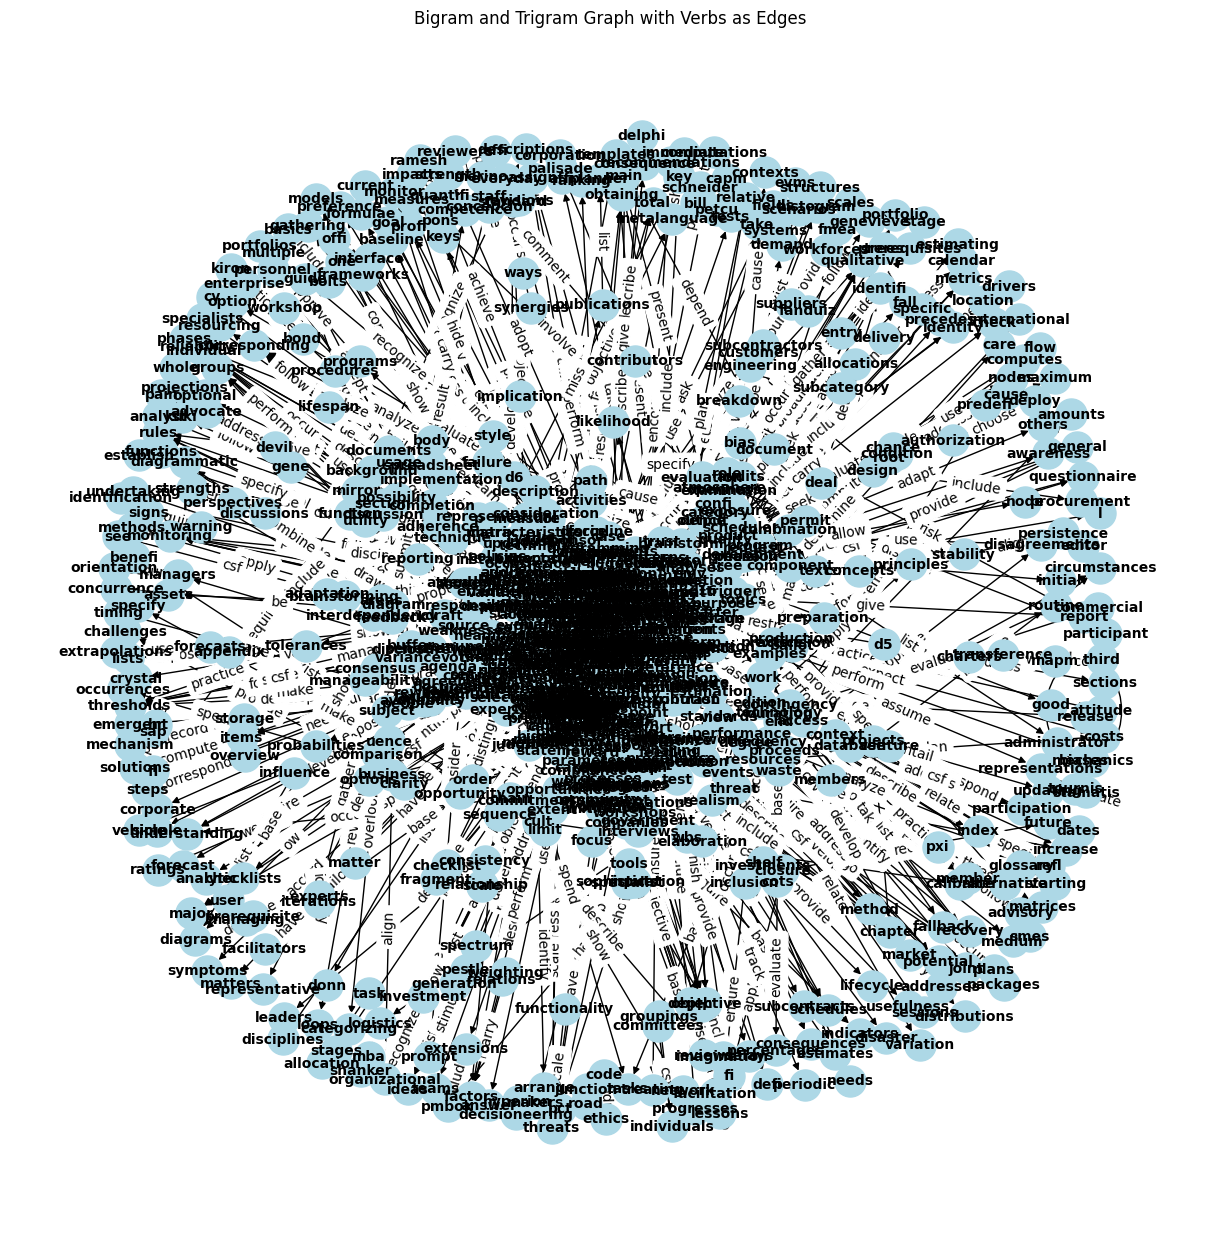

In [17]:
import spacy
import pandas as pd
import ast
import re
import networkx as nx
import matplotlib.pyplot as plt

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Function to extract verbs from text
def extract_verbs(text):
    doc = nlp(text)
    verbs = [token.lemma_ for token in doc if token.pos_ == 'VERB']
    return verbs

# Function to clean and extract bigrams and trigrams from the dataset
def extract_ngrams(counter_string):
    ngrams = re.findall(r"\('([^']+)', '([^']+)'\)", counter_string)
    return ngrams

# Load the data from CSV file
file_path = 'summarized_df.csv'  # Update this path if needed
data = pd.read_csv(file_path)

# Apply the function to extract bigrams and trigrams as lists of tuples
bigrams_cleaned = data['bigram_dict'].apply(extract_ngrams)
trigrams_cleaned = data['trigram_dict'].apply(extract_ngrams)

# Extract verbs from the summarized paragraphs
data['verbs'] = data['summarized_paragraphs'].apply(extract_verbs)

# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add bigrams as edges, using the first verb from the corresponding paragraph as the label
for idx, bigram_list in enumerate(bigrams_cleaned):
    verbs = data['verbs'].iloc[idx]
    for i, bigram in enumerate(bigram_list):
        verb = verbs[i % len(verbs)] if verbs else 'verb'
        G.add_edge(bigram[0], bigram[1], label=verb)

# Add trigrams as edges, using the first verb from the corresponding paragraph as the label
for idx, trigram_list in enumerate(trigrams_cleaned):
    verbs = data['verbs'].iloc[idx]
    for i, trigram in enumerate(trigram_list):
        verb = verbs[i % len(verbs)] if verbs else 'verb'
        G.add_edge(trigram[0], trigram[1], label=verb)
        G.add_edge(trigram[1], trigram[2], label=verb)

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Position the nodes for visualization
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', arrows=True)

# Draw edge labels with the extracted verbs
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Bigram and Trigram Graph with Verbs as Edges')
plt.show()


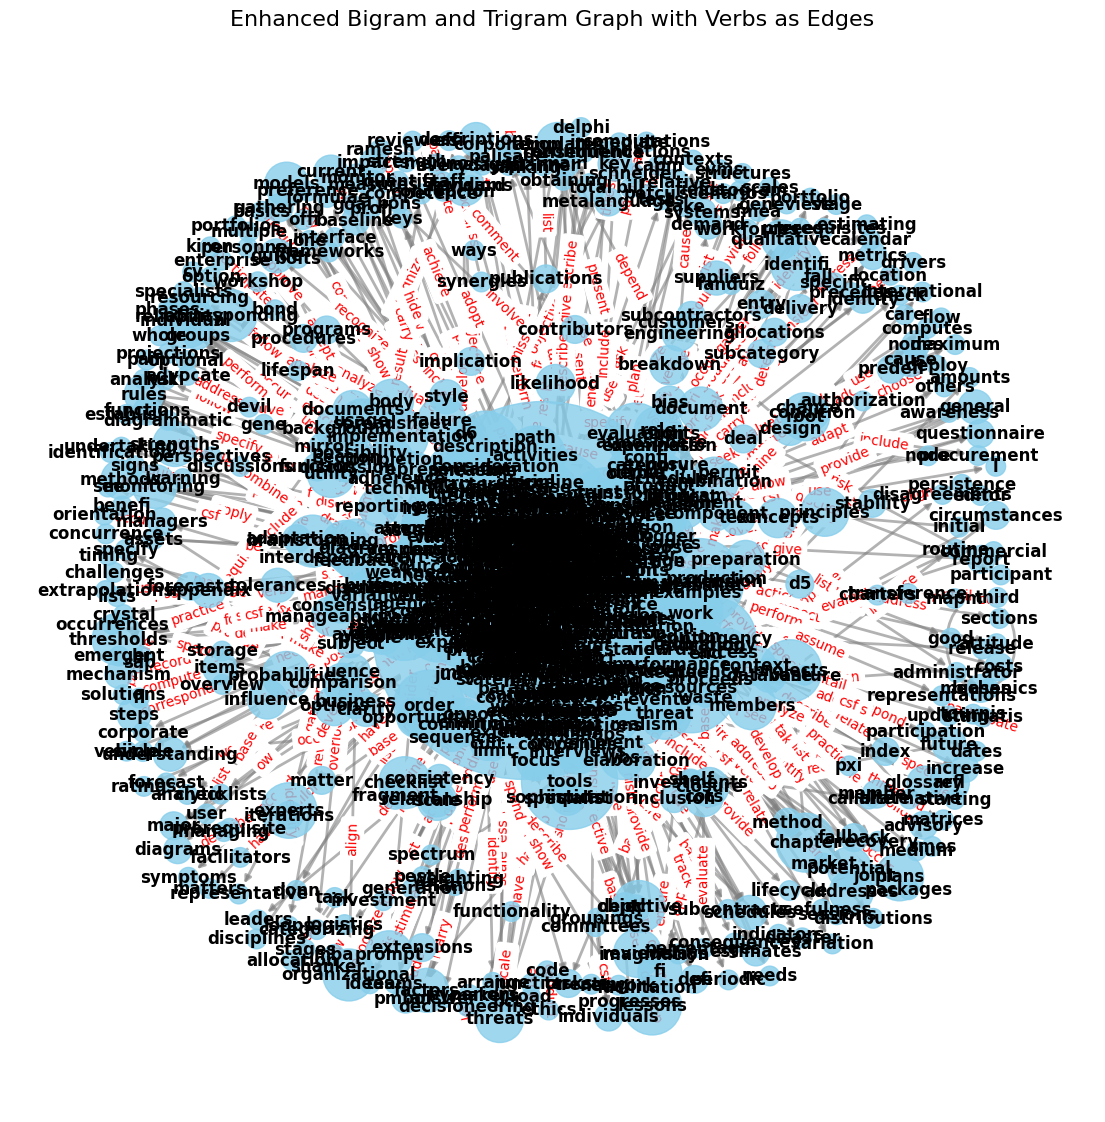

In [18]:
import spacy
import pandas as pd
import ast
import re
import networkx as nx
import matplotlib.pyplot as plt

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Function to extract verbs from text
def extract_verbs(text):
    doc = nlp(text)
    verbs = [token.lemma_ for token in doc if token.pos_ == 'VERB']
    return verbs

# Function to clean and extract bigrams and trigrams from the dataset
def extract_ngrams(counter_string):
    ngrams = re.findall(r"\('([^']+)', '([^']+)'\)", counter_string)
    return ngrams

# Load the data from CSV file
file_path = 'summarized_df.csv'  # Update this path if needed
data = pd.read_csv(file_path)

# Apply the function to extract bigrams and trigrams as lists of tuples
bigrams_cleaned = data['bigram_dict'].apply(extract_ngrams)
trigrams_cleaned = data['trigram_dict'].apply(extract_ngrams)

# Extract verbs from the summarized paragraphs
data['verbs'] = data['summarized_paragraphs'].apply(extract_verbs)

# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add bigrams as edges, using the first verb from the corresponding paragraph as the label
for idx, bigram_list in enumerate(bigrams_cleaned):
    verbs = data['verbs'].iloc[idx]
    for i, bigram in enumerate(bigram_list):
        verb = verbs[i % len(verbs)] if verbs else 'verb'
        G.add_edge(bigram[0], bigram[1], label=verb)

# Add trigrams as edges, using the first verb from the corresponding paragraph as the label
for idx, trigram_list in enumerate(trigrams_cleaned):
    verbs = data['verbs'].iloc[idx]
    for i, trigram in enumerate(trigram_list):
        verb = verbs[i % len(verbs)] if verbs else 'verb'
        G.add_edge(trigram[0], trigram[1], label=verb)
        G.add_edge(trigram[1], trigram[2], label=verb)

# Enhance node sizes based on degree (i.e., number of connections)
node_sizes = [G.degree(node) * 200 for node in G.nodes()]

# Use a spring layout to space nodes better
pos = nx.spring_layout(G, seed=42)

# Draw nodes with sizes based on their degree (number of connections)
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=node_sizes, alpha=0.8)

# Draw edges with thickness based on weight (currently uniform, can adjust if weighted data available)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, alpha=0.6, edge_color='gray', arrows=True)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif", font_weight="bold")

# Draw edge labels with verbs
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='red')

# Add title to the graph
plt.title('Enhanced Bigram and Trigram Graph with Verbs as Edges', size=16)

# Show the plot
plt.axis('off')  # Hide the axis
plt.show()


     Unnamed: 0                                           sections  \
0             0  1.1 Purpose of the Practice Standard for Proje...   
1             1             1.2 Project Risk Management Deﬁ nition   
2             2  1.3 Role of Project Risk Management in Project...   
3             3                  1.4 Good Risk Management Practice   
4             4  1.5 Critical Success Factors for Project Risk ...   
..          ...                                                ...   
170         170                          D.6.1.3 Risk Reassessment   
171         171                            D.6.1.4 Status Meetings   
172         172                             D.6.1.5 Trend Analysis   
173         173                          D.6.1.6 Variance Analysis   
174         174                                D.6.1.7 stop_tokens   

                                            paragraphs  \
0     The purpose of the  Practice Standard for Pro...   
1     The deﬁ nition of Project Risk Manage

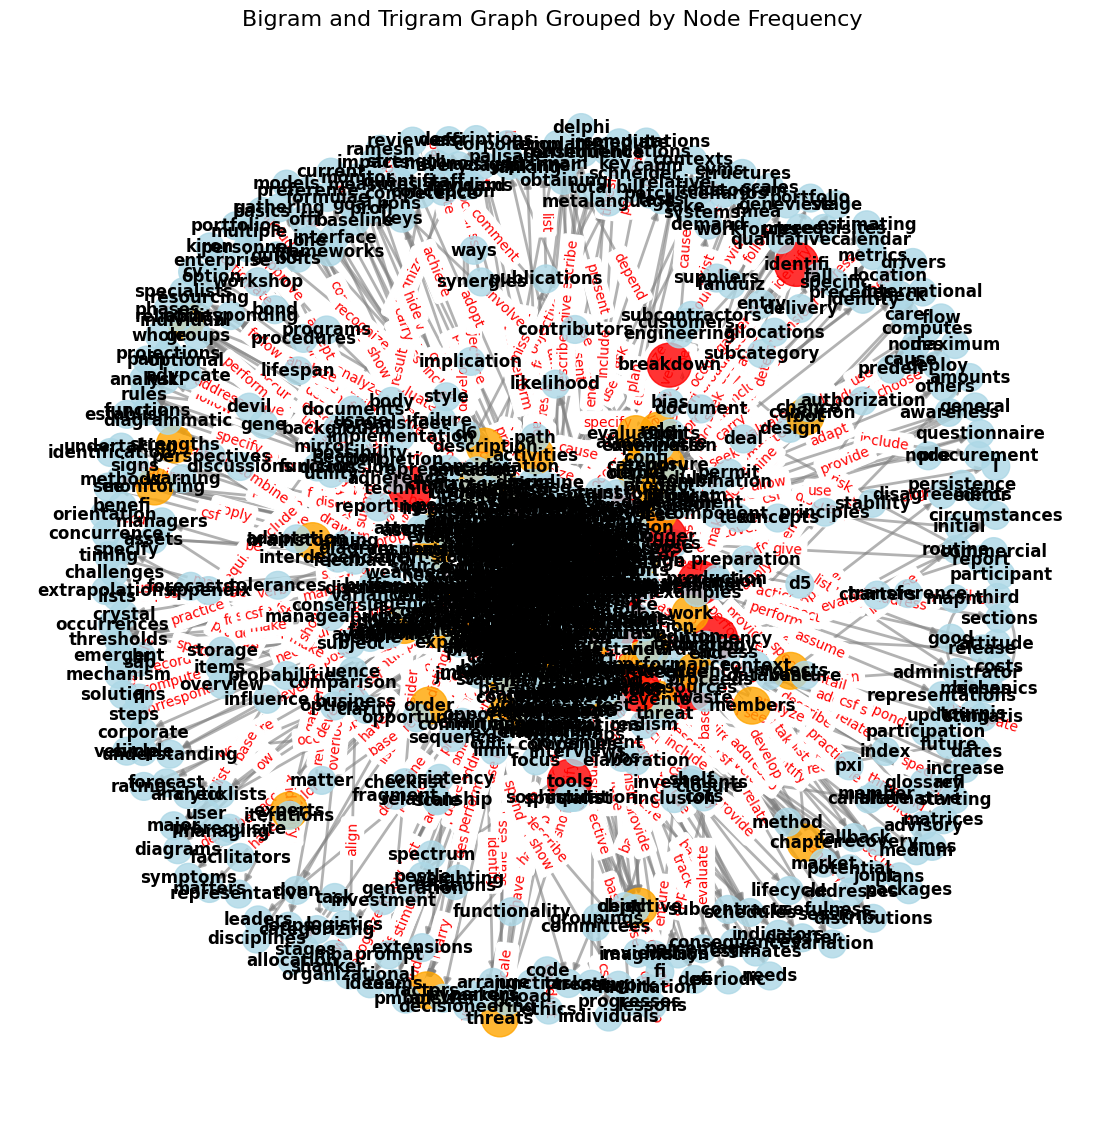

In [22]:
import spacy
import pandas as pd
import ast
import re
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Function to extract verbs from text
def extract_verbs(text):
    doc = nlp(text)
    verbs = [token.lemma_ for token in doc if token.pos_ == 'VERB']
    return verbs

# Function to clean and extract bigrams and trigrams from the dataset
def extract_ngrams(counter_string):
    ngrams = re.findall(r"\('([^']+)', '([^']+)'\)", counter_string)
    return ngrams

# Load the data from CSV file
file_path = 'summarized_df.csv'  # Update this path if needed
data = pd.read_csv(file_path)

# Apply the function to extract bigrams and trigrams as lists of tuples
bigrams_cleaned = data['bigram_dict'].apply(extract_ngrams)
trigrams_cleaned = data['trigram_dict'].apply(extract_ngrams)

# Extract verbs from the summarized paragraphs
data['verbs'] = data['summarized_paragraphs'].apply(extract_verbs)
print(data)
data.to_csv("processed_data.csv")
# Calculate node frequencies by combining bigrams and trigrams
word_counter = Counter()
for bigram_list in bigrams_cleaned:
    for bigram in bigram_list:
        word_counter.update(bigram)

for trigram_list in trigrams_cleaned:
    for trigram in trigram_list:
        word_counter.update(trigram)

# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add bigrams as edges, using the first verb from the corresponding paragraph as the label
for idx, bigram_list in enumerate(bigrams_cleaned):
    verbs = data['verbs'].iloc[idx]
    for i, bigram in enumerate(bigram_list):
        verb = verbs[i % len(verbs)] if verbs else 'verb'
        G.add_edge(bigram[0], bigram[1], label=verb)

# Add trigrams as edges, using the first verb from the corresponding paragraph as the label
for idx, trigram_list in enumerate(trigrams_cleaned):
    verbs = data['verbs'].iloc[idx]
    for i, trigram in enumerate(trigram_list):
        verb = verbs[i % len(verbs)] if verbs else 'verb'
        G.add_edge(trigram[0], trigram[1], label=verb)
        G.add_edge(trigram[1], trigram[2], label=verb)

# Group nodes by frequency ranges and assign colors
node_colors = []
node_sizes = []
for node in G.nodes():
    freq = word_counter[node]
    if freq > 20:
        node_colors.append('red')    # High frequency
        node_sizes.append(1000)
    elif 10 <= freq <= 20:
        node_colors.append('orange')  # Medium frequency
        node_sizes.append(700)
    else:
        node_colors.append('lightblue')  # Low frequency
        node_sizes.append(400)

# Use a spring layout to space nodes better
pos = nx.spring_layout(G, seed=42)

# Draw nodes with sizes and colors based on frequency
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)

# Draw edges with thickness based on weight (currently uniform, can adjust if weighted data available)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, alpha=0.6, edge_color='gray', arrows=True)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif", font_weight="bold")

# Draw edge labels with verbs
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='red')

# Add title to the graph
plt.title('Bigram and Trigram Graph Grouped by Node Frequency', size=16)

# Show the plot
plt.axis('off')  # Hide the axis
plt.show()


In [26]:
data["summarized_paragraphs"][3]

'Project Risk Management should be conducted in a way that is appropriate to the project. a large project that provides value to an important customer would theoretically require more resources, time, and attention to Project Risk Management than would a smaller, internal project.'

In [28]:
data.columns

Index(['Unnamed: 0', 'sections', 'paragraphs', 'bigram_dict', 'trigram_dict',
       'sentences', 'processed_paragraphs', 'summarized_paragraphs', 'verbs'],
      dtype='object')

In [30]:
data["processed_paragraphs"][0]

' The purpose of the  Practice Standard for Project Risk Management  is to  provide a standard for project  management practitioners and other stakeholders that de nes the aspects of Project Risk Management that  are recognized as good practice on most projects most of the time and  provide a standard that is globally  applicable and consistently applied. This practice standard has a descriptive purpose rather than one used for  training or educational purposes.   The  Practice Standard for Project Risk Management  covers risk management as it is applied to single  projects only. Like the  PMBOK    Guide   Fourth Edition, this practice standard does not cover risk in programs  or portfolios of projects.   Chapter 11 of the  PMBOK    Guide   Fourth Edition, is the basis for the  Practice Standard for Project Risk  Management . This practice standard is consistent with that chapter, emphasizing the concepts and principles  relating to Project Risk Management. It is aligned with other PMI

other try 